WNx - 06 June 2017
Practical Deep Learning I Lesson 4 CodeAlong

[Lesson4 JNB](https://github.com/fastai/courses/blob/master/deeplearning1/nbs/lesson4.ipynb)

In [1]:
import theano

In [2]:
import sys, os
sys.path.insert(1, os.path.join('utils'))

%matplotlib inline
import utils; reload(utils)
from utils import *
from __future__ import print_function, division

Using Theano backend.


In [3]:
path = "data/ml-latest-small/"
model_path = path + 'models/'
if not os.path.exists(model_path): os.mkdir(model_path)
batch_size = 64

## Set up Data

We're working with the movielens data, which contains one rating per row, like this:

In [4]:
ratings = pd.read_csv(path+'ratings.csv')
ratings.head()

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


In [5]:
len(ratings)

100004

Just for display purposes, let's read in the movie names too:

In [6]:
movie_names = pd.read_csv(path+'movies.csv').set_index('movieId')['title'].to_dict()

In [7]:
users = ratings.userId.unique()
movies = ratings.movieId.unique()

In [8]:
userid2idx = {o:i for i,o in enumerate(users)}
movieid2idx = {o:i for i,o in enumerate(movies)}

We update the movie and user ids so that they are contiguous integers, which we want when using embeddings.

In [9]:
ratings.movieId = ratings.movieId.apply(lambda x: movieid2idx[x])
ratings.userId = ratings.userId.apply(lambda x: userid2idx[x])

In [10]:
user_min, user_max, movie_min, movie_max = (ratings.userId.min(), 
    ratings.userId.max(), ratings.movieId.min(), ratings.movieId.max())
user_min, user_max, movie_min, movie_max

(0, 670, 0, 9065)

In [11]:
n_users = ratings.userId.nunique()
n_movies = ratings.movieId.nunique()
n_users, n_movies

(671, 9066)

This is the number of latent factors in each embedding.

In [12]:
n_factors = 50
np.random.seed = 42

Randomly split into training and validation.

In [13]:
msk = np.random.rand(len(ratings)) < 0.8
trn = ratings[msk]
val = ratings[~msk]

## Create subset for Excel

We create a crosstab of the most popular movies and most movie-addicted users which we'll copy into Excel for creating a simple example. This isn't necessary for any of the modeling below however.

In [14]:
g=ratings.groupby('userId')['rating'].count()
topUsers=g.sort_values(ascending=False)[:15]

In [15]:
g=ratings.groupby('movieId')['rating'].count()
topMovies=g.sort_values(ascending=False)[:15]

In [16]:
top_r = ratings.join(topUsers, rsuffix='_r', how='inner', on='userId')

In [17]:
top_r = top_r.join(topMovies, rsuffix='_r', how='inner', on='movieId')

In [18]:
pd.crosstab(top_r.userId, top_r.movieId, top_r.rating, aggfunc=np.sum)

movieId,27,49,57,72,79,89,92,99,143,179,180,197,402,417,505
userId,,,,,,,,,,,,,,,
14,3.0,5.0,1.0,3.0,4.0,4.0,5.0,2.0,5.0,5.0,4.0,5.0,5.0,2.0,5.0
29,5.0,5.0,5.0,4.0,5.0,4.0,4.0,5.0,4.0,4.0,5.0,5.0,3.0,4.0,5.0
72,4.0,5.0,5.0,4.0,5.0,3.0,4.5,5.0,4.5,5.0,5.0,5.0,4.5,5.0,4.0
211,5.0,4.0,4.0,3.0,5.0,3.0,4.0,4.5,4.0,NaN,3.0,3.0,5.0,3.0,NaN
212,2.5,NaN,2.0,5.0,NaN,4.0,2.5,NaN,5.0,5.0,3.0,3.0,4.0,3.0,2.0
293,3.0,NaN,4.0,4.0,4.0,3.0,NaN,3.0,4.0,4.0,4.5,4.0,4.5,4.0,NaN
310,3.0,3.0,5.0,4.5,5.0,4.5,2.0,4.5,4.0,3.0,4.5,4.5,4.0,3.0,4.0
379,5.0,5.0,5.0,4.0,NaN,4.0,5.0,4.0,4.0,4.0,NaN,3.0,5.0,4.0,4.0
451,4.0,5.0,4.0,5.0,4.0,4.0,5.0,5.0,4.0,4.0,4.0,4.0,2.0,3.5,5.0


## Dot Product

The most basic model is a dot product of a movie embedding and a user embedding. Let's see how well that works:

In [19]:
user_in = Input(shape=(1,), dtype='int64', name='user_in')
u = Embedding(n_users, n_factors, input_length=1, W_regularizer=l2(1e-4))(user_in)
movie_in = Input(shape=(1,), dtype='int64', name='movie_in')
m = Embedding(n_movies, n_factors, input_length=1, W_regularizer=l2(1e-4))(movie_in)

In [20]:
x = merge([u, m], mode='dot')
x = Flatten()(x)
model = Model([user_in, movie_in], x)
model.compile(Adam(0.001), loss='mse')

In [21]:
model.fit([trn.userId, trn.movieId], trn.rating, batch_size=64, nb_epoch=1, 
          validation_data=([val.userId, val.movieId], val.rating))

Train on 80245 samples, validate on 19759 samples
Epoch 1/1
80245/80245 [==============================] - 9s - loss: 9.9854 - val_loss: 4.3560


In [22]:
model.optimizer.lr=0.01

In [23]:
model.fit([trn.userId, trn.movieId], trn.rating, batch_size=64, nb_epoch=3, 
          validation_data=([val.userId, val.movieId], val.rating))

Train on 80245 samples, validate on 19759 samples
Epoch 1/3
80245/80245 [==============================] - 14s - loss: 3.1553 - val_loss: 2.8416
Epoch 2/3
80245/80245 [==============================] - 13s - loss: 2.4141 - val_loss: 2.6254
Epoch 3/3
80245/80245 [==============================] - 13s - loss: 2.2390 - val_loss: 2.5811


In [24]:
model.optimizer.lr=0.001
model.fit([trn.userId, trn.movieId], trn.rating, batch_size=64, nb_epoch=6, 
          validation_data=([val.userId, val.movieId], val.rating))

Train on 80245 samples, validate on 19759 samples
Epoch 1/6
80245/80245 [==============================] - 13s - loss: 2.1700 - val_loss: 2.5650
Epoch 2/6
80245/80245 [==============================] - 13s - loss: 2.1305 - val_loss: 2.5689
Epoch 3/6
80245/80245 [==============================] - 13s - loss: 2.1020 - val_loss: 2.5722
Epoch 4/6
80245/80245 [==============================] - 13s - loss: 2.0793 - val_loss: 2.5705
Epoch 5/6
80245/80245 [==============================] - 13s - loss: 2.0566 - val_loss: 2.5805
Epoch 6/6
80245/80245 [==============================] - 13s - loss: 2.0349 - val_loss: 2.5894


The [best benchmarks](http://www.librec.net/example.html) are a bit over 0.9, so this model doesn't seem to be working that well...

## Bias

The problem is likely to be that we don't have bias terms - that is, a single bias for each user and each movie representing how positive or negative each user is, and how good each movie is. We can add that easily by simply creating an embedding with one output for each movie and each user, and adding it to our output.

In [25]:
def embedding_input(name, n_in, n_out, reg):
    inp = Input(shape=(1,), dtype='int64', name=name)
    return inp, Embedding(n_in, n_out, input_length=1, W_regularizer=l2(reg))(inp)

In [26]:
user_in, u = embedding_input('user_in', n_users, n_factors, 1e-4)
movie_in, m = embedding_input('movie_in', n_movies, n_factors, 1e-4)

In [27]:
def create_bias(inp, n_in):
    x = Embedding(n_in, 1, input_length=1)(inp)
    return Flatten()(x)

In [28]:
ub = create_bias(user_in, n_users)
mb = create_bias(movie_in, n_movies)

In [29]:
x = merge([u, m], mode='dot')
x = Flatten()(x)
x = merge([x, ub], mode='sum')
x = merge([x, mb], mode='sum')
model = Model([user_in, movie_in], x)
model.compile(Adam(0.001), loss='mse')

In [30]:
model.fit([trn.userId, trn.movieId], trn.rating, batch_size=64, nb_epoch=1, 
          validation_data=([val.userId, val.movieId], val.rating))

Train on 80245 samples, validate on 19759 samples
Epoch 1/1
80245/80245 [==============================] - 9s - loss: 8.8588 - val_loss: 3.5627


In [31]:
model.optimizer.lr = 0.01
model.fit([trn.userId, trn.movieId], trn.rating, batch_size=64, nb_epoch=6, verbose=0,
          validation_data=([val.userId, val.movieId], val.rating))

In [32]:
model.optimizer.lr = 0.001
model.fit([trn.userId, trn.movieId], trn.rating, batch_size=64, nb_epoch=10, verbose=0,
          validation_data=([val.userId, val.movieId], val.rating))

In [33]:
model.fit([trn.userId, trn.movieId], trn.rating, batch_size=64, nb_epoch=5, 
          validation_data=([val.userId, val.movieId], val.rating))

Train on 80245 samples, validate on 19759 samples
Epoch 1/5
80245/80245 [==============================] - 15s - loss: 0.9221 - val_loss: 1.2613
Epoch 2/5
80245/80245 [==============================] - 15s - loss: 0.8785 - val_loss: 1.2293
Epoch 3/5
80245/80245 [==============================] - 15s - loss: 0.8382 - val_loss: 1.2012
Epoch 4/5
80245/80245 [==============================] - 15s - loss: 0.8007 - val_loss: 1.1759
Epoch 5/5
80245/80245 [==============================] - 15s - loss: 0.7665 - val_loss: 1.1518


This result is quite a bit better than the best benchmarks we could find with a quick Google search (*at least the training loss is < 0.89*) - so looks like a great approach!

In [34]:
model.save_weights(model_path + 'bias.h5')
model.load_weights(model_path + 'bias.h5')

e can use the model to generate predictions by passing a pair of ints - a user id and a movie id. For instance, this predicts that user #3 would really enjoy movie #6.

In [35]:
model.predict([np.array([3]), np.array([6])])

array([[ 5.1417]], dtype=float32)

## Analyze Results

To make the analysis of the factors more interesting, we'll restrict it to the top 2000 most popular movies.

In [36]:
g = ratings.groupby('movieId')['rating'].count()
topMovies = g.sort_values(ascending=False)[:2000]
topMovies = np.array(topMovies.index)

First, we'll look at the movie bias term. We create a 'model' - which in Keras is simply a way of associating one or more inputs with one or more outputs, using the functional API. Here, our input is the movie id (a single id), and the output is the movie bias (a single float).

In [37]:
get_movie_bias = Model(movie_in, mb)
movie_bias = get_movie_bias.predict(topMovies)
movie_ratings = [(b[0], movie_names[movies[i]]) for i, b in zip(topMovies, movie_bias)]

Now we can look at the top and bottom rated movies. These ratings are correected for different levels of reviewer sentiment, as well as different types of movies that different reviewers watch.

In [38]:
sorted(movie_ratings, key=itemgetter(0))[:15]

[(-0.37409157, 'Battlefield Earth (2000)'),
 (-0.16810741, 'Police Academy 6: City Under Siege (1989)'),
 (-0.11745852, 'Jaws 3-D (1983)'),
 (-0.096804537, 'Anaconda (1997)'),
 (-0.092195801, 'Super Mario Bros. (1993)'),
 (-0.060210325, '2 Fast 2 Furious (Fast and the Furious 2, The) (2003)'),
 (-0.026771871, 'Spice World (1997)'),
 (-0.022201568, 'Speed 2: Cruise Control (1997)'),
 (-0.015480183, 'Little Nicky (2000)'),
 (-0.0082877874, 'Wild Wild West (1999)'),
 (-0.0034693303, 'Police Academy 5: Assignment: Miami Beach (1988)'),
 (0.005796887, 'Blade: Trinity (2004)'),
 (0.023488335, 'Batman & Robin (1997)'),
 (0.051879421, 'Bedazzled (2000)'),
 (0.064242974, 'Road to Wellville, The (1994)')]

In [39]:
sorted(movie_ratings, key=itemgetter(0), reverse=True)[:15]

[(1.3600034, 'Shawshank Redemption, The (1994)'),
 (1.3392947, 'Avengers: Age of Ultron (2015)'),
 (1.3371743, 'Rush (2013)'),
 (1.3186955, 'Harry Potter and the Deathly Hallows: Part 2 (2011)'),
 (1.3176774, "Howl's Moving Castle (Hauru no ugoku shiro) (2004)"),
 (1.3121805, 'The Imitation Game (2014)'),
 (1.3054557, 'Cyrano de Bergerac (1990)'),
 (1.3002607, 'My Neighbor Totoro (Tonari no Totoro) (1988)'),
 (1.2998208, 'Captain America: The Winter Soldier (2014)'),
 (1.2980639, 'Last King of Scotland, The (2006)'),
 (1.2959077, 'Persuasion (1995)'),
 (1.2762462, 'Argo (2012)'),
 (1.2710924, 'Ideal Husband, An (1999)'),
 (1.2664735, "Amores Perros (Love's a Bitch) (2000)"),
 (1.2593609, 'Midnight in Paris (2011)')]

*Hey! I liked Avengers, lol*

We can now do the same thing for the embeddings.

In [40]:
get_movie_emb = Model(movie_in, m)
movie_emb = np.squeeze(get_movie_emb.predict([topMovies]))
movie_emb.shape

(2000, 50)

Because it's hard to interpret 50 embeddings, we use [PCA](https://plot.ly/ipython-notebooks/principal-component-analysis/) (*Principal Component Analysis*) to simplify them down to just 3 vectors.

In [42]:
from sklearn.decomposition import PCA
pca = PCA(n_components=3)
movie_pca = pca.fit(movie_emb.T).components_

In [43]:
fac0 = movie_pca[0]
movie_comp = [(f, movie_names[movies[i]]) for f,i in zip(fac0, topMovies)]

Here's the 1st component. It seems to be 'critically acclaimed' or 'classic'.

In [44]:
sorted(movie_comp, key=itemgetter(0), reverse=True)[:10]

[(0.050404081239393349, 'Usual Suspects, The (1995)'),
 (0.049405778938593117, 'Monty Python and the Holy Grail (1975)'),
 (0.049341389000133816, 'Star Wars: Episode IV - A New Hope (1977)'),
 (0.049178587863818263, 'Being John Malkovich (1999)'),
 (0.049108857969055841, 'Wallace & Gromit: The Wrong Trousers (1993)'),
 (0.048995443904681385, 'Seven (a.k.a. Se7en) (1995)'),
 (0.048734528633280816, 'Shakespeare in Love (1998)'),
 (0.048151800105313912, 'Silence of the Lambs, The (1991)'),
 (0.047427782084031117,
  'Star Wars: Episode V - The Empire Strikes Back (1980)'),
 (0.04706201486881692, 'Star Wars: Episode VI - Return of the Jedi (1983)')]

In [45]:
sorted(movie_comp, key=itemgetter(0))[:10]

[(-0.010843587311752508, 'Police Academy 6: City Under Siege (1989)'),
 (-0.01022765793929409, 'Battlefield Earth (2000)'),
 (-0.0097202250733280891, 'Police Academy 5: Assignment: Miami Beach (1988)'),
 (-0.0092548602200794756, 'Wild Wild West (1999)'),
 (-0.0090160855859656077, 'House on Haunted Hill (1999)'),
 (-0.0074054503822722686, "You Don't Mess with the Zohan (2008)"),
 (-0.0071190792853722965, 'Blade: Trinity (2004)'),
 (-0.0070356756968438586, 'Police Academy 3: Back in Training (1986)'),
 (-0.007016137927139115, 'Evolution (2001)'),
 (-0.0070035011980512487, 'Bio-Dome (1996)')]

In [46]:
fac1 = movie_pca[1]
movie_comp = [(f, movie_names[movies[i]]) for f,i in zip(fac1, topMovies)]

The 2nd is 'hollywood blockbuster'.

In [48]:
sorted(movie_comp, key=itemgetter(0), reverse=True)[:10]

[(0.10656701849408552, 'Independence Day (a.k.a. ID4) (1996)'),
 (0.091366897282317019, 'Armageddon (1998)'),
 (0.084390172324903062, 'Stargate (1994)'),
 (0.073669682353195862, 'Speed (1994)'),
 (0.069852425852792777, 'Outbreak (1995)'),
 (0.06980229689141014, 'Rock, The (1996)'),
 (0.067526886804469555, 'Titanic (1997)'),
 (0.067169954708450996, 'Ghost (1990)'),
 (0.066400318206397538, 'Jurassic Park (1993)'),
 (0.065564951929342197, 'True Lies (1994)')]

In [50]:
sorted(movie_comp, key=itemgetter(0))[:10]

[(-0.064078812432453641, 'Annie Hall (1977)'),
 (-0.064040763970977202, 'City Lights (1931)'),
 (-0.05974555651127627, 'Brokeback Mountain (2005)'),
 (-0.056859614175771178, 'Manhattan (1979)'),
 (-0.054999029304882423, 'Vertigo (1958)'),
 (-0.053469671936228647, 'Apocalypse Now (1979)'),
 (-0.053439086447603527, '8 1/2 (8\xc2\xbd) (1963)'),
 (-0.053188771476367663, 'Bringing Up Baby (1938)'),
 (-0.0518622353612977, 'Clockwork Orange, A (1971)'),
 (-0.049767915936258761, 'Chinatown (1974)')]

In [51]:
fac2 = movie_pca[2]
movie_comp = [(f, movie_names[movies[i]]) for f,i in zip(fac2, topMovies)]

The 3rd is 'violent vs happy'.

In [52]:
sorted(movie_comp, key=itemgetter(0), reverse=True)[:10]

[(0.080651421311917465, 'Sabrina (1995)'),
 (0.068927078419200025, 'Absolute Power (1997)'),
 (0.067748750512838449, 'Bend It Like Beckham (2002)'),
 (0.06342536163669453,
  'Chronicles of Narnia: The Lion, the Witch and the Wardrobe, The (2005)'),
 (0.062547486514037312, 'Legally Blonde (2001)'),
 (0.060699140297812405, 'Double Jeopardy (1999)'),
 (0.059316332984105234, 'Lilo & Stitch (2002)'),
 (0.057891674984747107, 'Much Ado About Nothing (1993)'),
 (0.057209200730924351, 'Roman Holiday (1953)'),
 (0.056882432377863903, 'Chicken Run (2000)')]

In [53]:
sorted(movie_comp, key=itemgetter(0))[:10]

[(-0.11341223018784412, 'Dumb & Dumber (Dumb and Dumber) (1994)'),
 (-0.10841361405638501, 'Seven (a.k.a. Se7en) (1995)'),
 (-0.079503991832060056, 'Silence of the Lambs, The (1991)'),
 (-0.079390542149746557, 'Fight Club (1999)'),
 (-0.073401003470741202, 'Matrix, The (1999)'),
 (-0.071831464023471403, 'Twelve Monkeys (a.k.a. 12 Monkeys) (1995)'),
 (-0.070883140512160894, 'Austin Powers: International Man of Mystery (1997)'),
 (-0.070870507857564907, 'Lord of the Rings: The Two Towers, The (2002)'),
 (-0.069830273389860906, 'Pulp Fiction (1994)'),
 (-0.069620879571228991, 'Ace Ventura: Pet Detective (1994)')]

We can draw a picture to see how various movies appear on the map of these components. This picture shows the 1st and 3rd components.

In [54]:
import sys
stdout, stderr = sys.stdout, sys.stderr # save notebook stdout and stderr
reload(sys)
sys.setdefaultencoding('utf-8')
sys.stdout, sys.stderr = stdout, stderr # restore notebook stdout and stderr

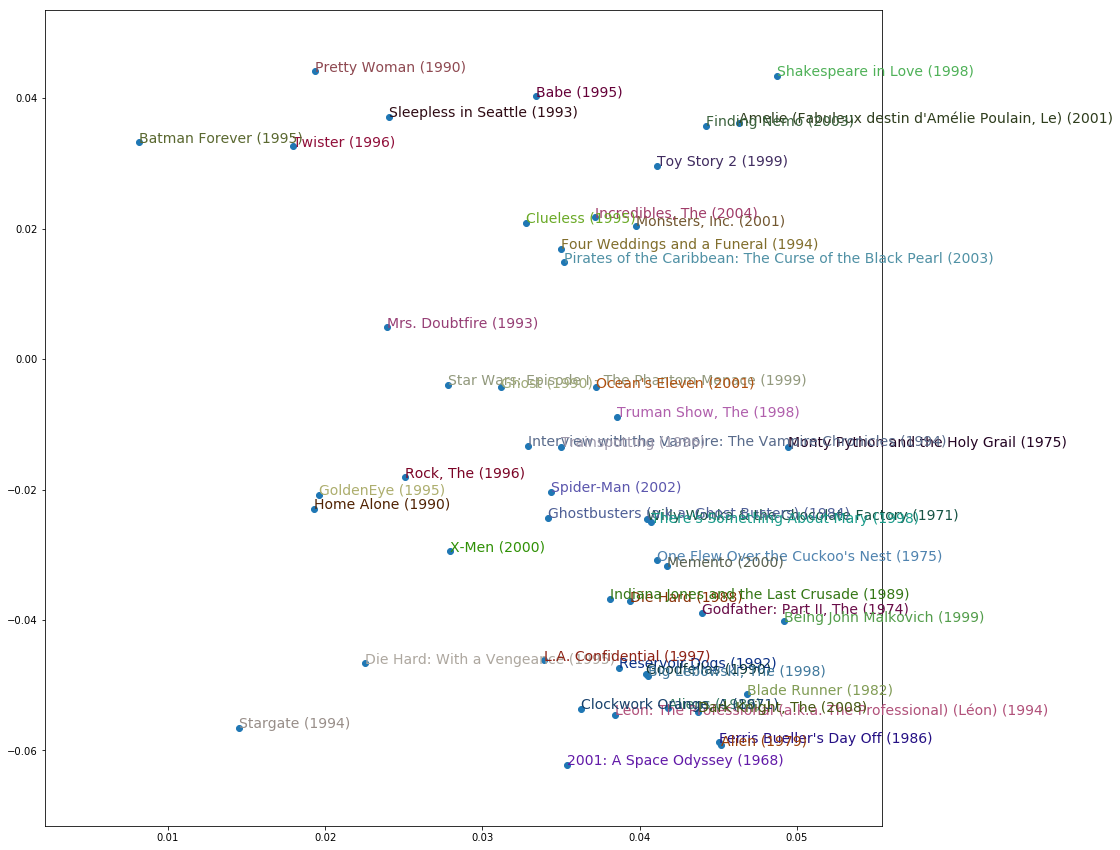

In [55]:
start=50; end=100
X = fac0[start:end]
Y = fac2[start:end]
plt.figure(figsize=(15,15))
plt.scatter(X, Y)
for i, x, y in zip(topMovies[start:end], X, Y):
    plt.text(x,y,movie_names[movies[i]], color=np.random.rand(3)*0.7, fontsize=14)
plt.show()

## Neural Net

Rather than creating a special purpose architecture (like our dot-product with bias earlier), it's often both easier and more accurate to use a standard neural network. Let's try it! Here, we simply concatenate the user and movie embeddings into a single vector, which we feed into the neural net.

In [56]:
user_in, u = embedding_input('user_in', n_users, n_factors, 1e-4)
movie_in, m = embedding_input('movie_in', n_movies, n_factors, 1e-4)

In [57]:
x = merge([u,m], mode='concat')
x = Flatten()(x)
x = Dropout(0.3)(x)
x = Dense(70, activation='relu')(x)
x = Dropout(0.75)(x)
x = Dense(1)(x)
NN = Model([user_in, movie_in], x)
NN.compile(Adam(0.001), loss='mse')

In [58]:
NN.fit([trn.userId, trn.movieId], trn.rating, batch_size=64, nb_epoch=8,
          validation_data=([val.userId, val.movieId], val.rating))

Train on 80245 samples, validate on 19759 samples
Epoch 1/8
80245/80245 [==============================] - 13s - loss: 2.4325 - val_loss: 0.9320
Epoch 2/8
80245/80245 [==============================] - 24s - loss: 1.4523 - val_loss: 0.9076
Epoch 3/8
80245/80245 [==============================] - 20s - loss: 1.2157 - val_loss: 0.8729
Epoch 4/8
80245/80245 [==============================] - 20s - loss: 1.0379 - val_loss: 0.8640
Epoch 5/8
80245/80245 [==============================] - 18s - loss: 0.9154 - val_loss: 0.8483
Epoch 6/8
80245/80245 [==============================] - 17s - loss: 0.8477 - val_loss: 0.8383
Epoch 7/8
80245/80245 [==============================] - 16s - loss: 0.8194 - val_loss: 0.8341
Epoch 8/8
80245/80245 [==============================] - 17s - loss: 0.8124 - val_loss: 0.8334


This improves on our already impressive accuracy even further!